In [1]:
### Notebook for plotting graphics from polygons

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon
from bs4 import BeautifulSoup


In [2]:
#### Load data from kml file exported by Google Earth

file_path = ('data/kml/ballparks.kml')

with open(file_path) as file:

    xml_data = file.read()



# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')

folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')
# layers = soup.Document.Folder.Folder
# polygons = soup.Document.Folder.Placemark.Polygon

## Create a dataframe to hold the data parsed from xml
df = pd.DataFrame(columns=['field', 'foul', 'fop'])


## Loop through the folders and extract the data
i = 0   

for i in range(len(list)):

    folders = list[i]
    field_name = folders.find('name').text
    foul = folders.find_all('coordinates')[0].text
    fop = folders.find_all('coordinates')[1].text

    row = {
        'field': field_name,
        'foul': foul,
        'fop': fop
    }

    i+=1

    df = df.append(row, ignore_index=True)

## Cleaning
# remove new line and and space characters from coordinates
df = df.replace(r'\n','', regex=True) 
df = df.replace(r'\t','', regex=True) 

## Drop any duplicate rows
df = df.drop_duplicates(subset=['field'], keep='first')

## Drop any rows with empty fields
df = df[(df != 0).all(1)]

# ## remove any numberic characters and . from field names
# # There shouldn't be any anymore because of the validation I did before exporting kml
# df['field'] = df['field'].str.replace(r'\d+', '')

## Parse field names to get level column using regex
import re
re_mlb = re.compile(r'mlb', re.IGNORECASE)
re_pro = re.compile(r'pro', re.IGNORECASE)
re_college = re.compile(r'college', re.IGNORECASE)
re_youth = re.compile(r'youth', re.IGNORECASE)
re_muni = re.compile(r'muni', re.IGNORECASE)

df['level'] = df['field'].apply(lambda x: 'mlb' 
        if re_mlb.search(x) else 'pro' 
        if re_pro.search(x) else 'college' 
        if re_college.search(x) else 'youth' 
        if re_youth.search(x) else 'muni' 
        if re_muni.search(x) else 'high_school')

# clean up the field names
# remove the level from the field name
df['field'] = df['field'].str.replace(r'MLB', '')
df['field'] = df['field'].str.replace(r'pro', '')
df['field'] = df['field'].str.replace(r'college', '')
df['field'] = df['field'].str.replace(r'High School', 'HS')
# remove - from end of field name
df['field'] = df['field'].str.replace(r'- $', '')

## Output test csv
# df.to_csv('TEMP/level2_tost.csv', index=False)

df['foul_poly'] = df['foul'].apply(lambda x: {'type': 'Polygon', 'coordinates': [[tuple(map(float, coord.split(','))) for coord in x.split()]]})
df['fop_poly'] = df['fop'].apply(lambda x: {'type': 'Polygon', 'coordinates': [[tuple(map(float, coord.split(','))) for coord in x.split()]]})

C:\Users\Justin\AppData\Local\Temp\ipykernel_14956\3853256035.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_14956\3853256035.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_14956\3853256035.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_14956\3853256035.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\Justin\AppData\Loca

In [3]:
############ TRANSFORM ###############


# get home plate coords for each foul and fop
## this will be the first coordinate in the list of coordinates

df['foul_hp'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[0:2])))
df['fop_hp'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[0:2])))

# FLIP THE COORDINATES
df['foul_hp'] = df['foul_hp'].apply(lambda x: (x[1], x[0]))
df['fop_hp'] = df['fop_hp'].apply(lambda x: (x[1], x[0]))

## Drop the extra zeros from the coordinates in the foul and fop columns
df['foul'] = df['foul'].apply(lambda x: x.replace(',0', ','))
df['fop'] = df['fop'].apply(lambda x: x.replace(',0', ','))

## get the second coordinate in the list of coordinates
df['foul_2nd'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[3:5])))
df['fop_2nd'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[3:5])))

# Get the last coordinates in the list of coordinates
df['foul_last'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[-3:-1])))
df['fop_last'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[-3:-1])))
# Filp the coordinates
df['foul_last'] = df['foul_last'].apply(lambda x: (x[1], x[0]))
df['fop_last'] = df['fop_last'].apply(lambda x: (x[1], x[0]))

df['foul_2nd_last'] = df['foul'].apply(lambda x: tuple(map(float, x.split(',')[-6:-4])))
df['fop_2nd_last'] = df['fop'].apply(lambda x: tuple(map(float, x.split(',')[-6:-4])))

In [4]:
#### Merge the foul_poly and fop_poly columns into a single polygon column

import shapely.geometry as geom
import shapely.ops as ops
from shapely import affinity

df['poly'] = df.apply(lambda x: ops.unary_union([geom.shape(x['foul_poly']), geom.shape(x['fop_poly'])]), axis=1)

### Project the polygon to a projected coordinate system and rotate it to be horizontal
import pyproj
from shapely.ops import transform

# project to a projected coordinate system and save to a column
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
df['poly_proj'] = df['poly'].apply(lambda x: transform(project, x))

# # find the difference between the foul_angle and 135

# df['angle_diff'] = df['foul_angle'].apply(lambda x: abs(x - 135))

# #### MOVED TO NEXT BLOCK TOT ALTER AND TEST
# # rotate the polygon to be horizontal and save to a column
# df['poly_rot'] = df.apply(lambda x: affinity.rotate(x['poly_proj'], x['angle_diff'], origin=x['foul_hp']), axis=1)

c:\Users\Justin\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [5]:
######### 12-30-22######

## I think this simple method might give me the adjustment angle I need to find


angle_list = []
delta_list = []

for i in range(len(df)):
      try:
            a = np.array(df['fop_hp'][i])
            b = np.array(df['fop_last'][i])
            c = np.array(df['fop_2nd'][i])

            ba = a - b
            bc = c - b

            s = np.arctan2(*ba)
            if s < 0:
                  s += 2*np.pi

            e = np.arctan2(*bc)
            if e < 0:
                  e += 2*np.pi

            delta = e - s
            angle = np.degrees(delta)
            
            angle_list.append(angle)
            delta_list.append(delta)
            
            
      except:
            delta_list.append(np.nan)
            angle_list.append(np.nan)

      

df['delta'] = delta_list
df['angle'] = angle_list
df.info()

### Cleaning
## drop rows with null values

df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 0 to 652
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   field          646 non-null    object 
 1   foul           646 non-null    object 
 2   fop            646 non-null    object 
 3   level          646 non-null    object 
 4   foul_poly      646 non-null    object 
 5   fop_poly       646 non-null    object 
 6   foul_hp        646 non-null    object 
 7   fop_hp         646 non-null    object 
 8   foul_2nd       646 non-null    object 
 9   fop_2nd        646 non-null    object 
 10  foul_last      646 non-null    object 
 11  fop_last       646 non-null    object 
 12  foul_2nd_last  646 non-null    object 
 13  fop_2nd_last   646 non-null    object 
 14  poly           646 non-null    object 
 15  poly_proj      646 non-null    object 
 16  delta          639 non-null    float64
 17  angle          639 non-null    float64
dtypes: float64

count    639.000000
mean     146.328292
std      128.686411
min        0.000000
25%       12.451279
50%      116.368790
75%      272.628432
max      359.951543
Name: angle, dtype: float64

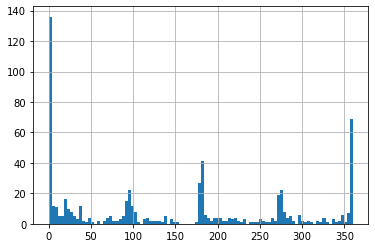

In [6]:
df['angle'].hist(bins=100)

df['angle'].describe()

In [7]:
########### 12/30/22 ##########
# Taken from above

#### Merge the foul_poly and fop_poly columns into a single polygon column

import shapely.geometry as geom
import shapely.ops as ops
from shapely import affinity

df['poly'] = df.apply(lambda x: ops.unary_union([geom.shape(x['foul_poly']), geom.shape(x['fop_poly'])]), axis=1)

### Project the polygon to a projected coordinate system and rotate it to be horizontal
import pyproj
from shapely.ops import transform

# project to a projected coordinate system and save to a column
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True).transform
df['poly_proj'] = df['poly'].apply(lambda x: transform(project, x))

## make a shapely point out of the foul_hp and save to a column
df['foul_hp'] = df['foul_hp'].apply(lambda x: geom.Point(x))
df['hp_proj'] = df['foul_hp'].apply(lambda x: transform(project, x))

# # rotate the polygon to be horizontal and save to a column and skip null values

## seperate dataframe into two dataframes, one with angles above 45 and one with angles below 45
df_above = df[df['angle'] > 45]
df_below = df[df['angle'] < 45]


for i in range(len(df_above)):
    try:    
        df_above['poly_rot'] = df.apply(lambda x: affinity.rotate(x['poly_proj'], -abs(x['angle']-45), origin=x['foul_hp']), axis=1)
    except:
        pass

for i in range(len(df_below)):
    try:
        df_below['poly_rot'] = df.apply(lambda x: affinity.rotate(x['poly_proj'], (45 - x['angle']), origin=x['foul_hp']), axis=1)
    except:
        pass
    
## Recombine the daaframes

df = pd.concat([df_above, df_below])

c:\Users\Justin\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
c:\Users\Justin\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\Justin\AppData\Local\Temp\ipykernel_14956\2702197573.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_above['poly_ro

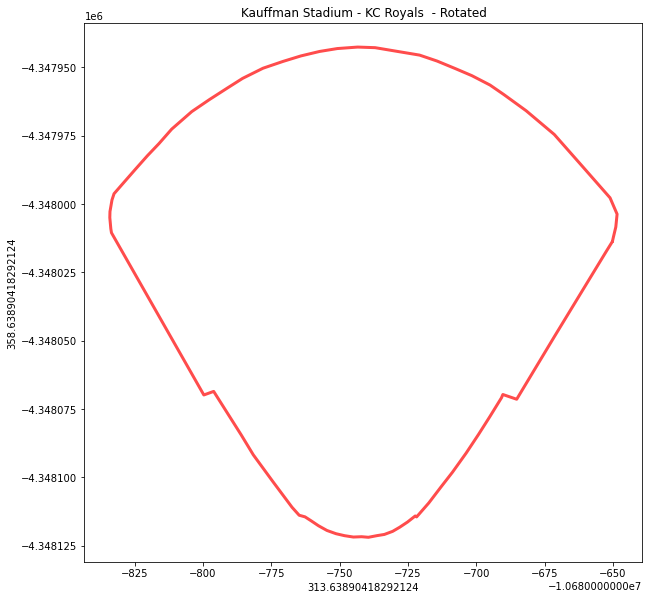

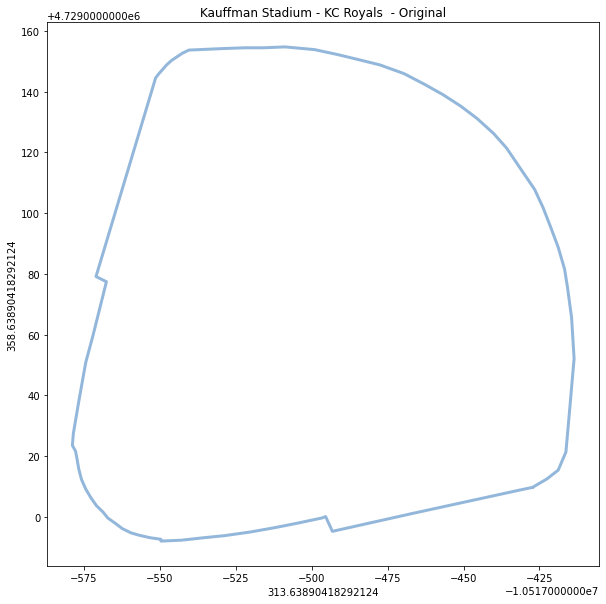

In [11]:
#### 12-30-22 ####
# Test some plot and take better look at rotate function

import matplotlib.pyplot as plt
import descartes

i = 3

shape = geom.shape(df['poly_proj'][i])
shape_rot = geom.shape(df['poly_rot'][i])


x, y = shape.exterior.xy
x2, y2 = shape_rot.exterior.xy

### Create a point to plot from the home plate coordinates
hp = df['hp_proj'][i]


## Rotated polygon
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x2, y2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

ax.set_aspect('equal')
ax.set_title(df['field'][i] + ' - Rotated')
ax.set_ylabel(df['angle'][i])
ax.set_xlabel(df['angle'][i]-45)

plt.show()

## Original polygon
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

ax.set_aspect('equal')
ax.set_title(df['field'][i] + ' - Original')
ax.set_ylabel(df['angle'][i])
ax.set_xlabel(df['angle'][i]-45)

plt.show()